# 🎯 CNN Model Training & Evaluation
This notebook trains a Convolutional Neural Network (CNN) to classify emotions from audio-based mel spectrograms.
We'll cover data loading, preprocessing, model design, training, and rich evaluation with visual outputs.

## 1. 📦 Imports and Configuration

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image


## 2. 📂 Data Loading and Preprocessing
We load the preprocessed spectrogram metadata, split the data, and convert images to arrays suitable for model training.

In [2]:
df = pd.read_csv("spectrogram_metadata.csv")
print(f"Total samples: {len(df)}")
df['label'] = df['label'].astype(str)
df['label_idx'] = df['label'].astype('category').cat.codes

label_map = dict(enumerate(df['label'].astype('category').cat.categories))
print("Label mapping:", label_map)


Total samples: 2880
Label mapping: {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 1843, Val: 461, Test: 576


In [4]:
IMG_SIZE = (224, 224)

def load_image(path):
    img = Image.open(path).convert("RGB")
    img = img.resize(IMG_SIZE)
    return np.array(img) / 255.0


In [5]:
def load_data(df):
    X = np.array([load_image(path) for path in df['image_path']])
    y = df['label_idx'].values
    return X, y

X_train, y_train = load_data(train_df)
X_val, y_val = load_data(val_df)
X_test, y_test = load_data(test_df)

print(f"X_train shape: {X_train.shape}")


X_train shape: (1843, 224, 224, 3)


### 📊 Visualizing Class Distribution

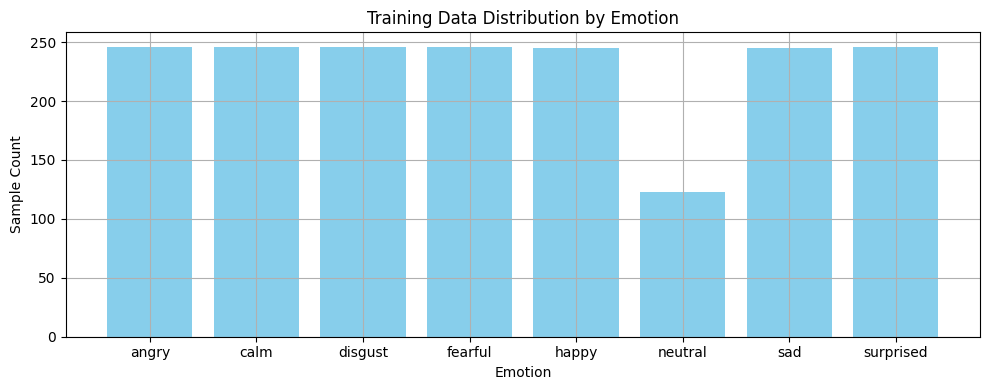

In [6]:
import matplotlib.pyplot as plt
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
labels = [label_map[i] for i in unique]
plt.figure(figsize=(10, 4))
plt.bar(labels, counts, color='skyblue')
plt.title('Training Data Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Sample Count')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. 🧠 Model Architecture
We define a CNN model suitable for image classification.

In [7]:
model = models.Sequential([
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(len(label_map), activation='softmax')
])

/Volumes/Rogueware/AI Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. ⚙️ Compile and Configure Training
Use Adam optimizer, sparse categorical crossentropy, and callbacks to improve learning.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6, verbose=1)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## 5. 🚀 Model Training
We train the model and track its performance over epochs.

In [9]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5,
    min_lr=1e-6,
    verbose=1
)

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=20,                  
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, lr_scheduler]
)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 677ms/step - accuracy: 0.1492 - loss: 2.2574 - val_accuracy: 0.3319 - val_loss: 1.9183 - learning_rate: 0.0010
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 593ms/step - accuracy: 0.3037 - loss: 1.8361 - val_accuracy: 0.4729 - val_loss: 1.4223 - learning_rate: 0.0010
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 543ms/step - accuracy: 0.4382 - loss: 1.4716 - val_accuracy: 0.5141 - val_loss: 1.2281 - learning_rate: 0.0010
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 522ms/step - accuracy: 0.5591 - loss: 1.2104 - val_accuracy: 0.6616 - val_loss: 1.0659 - learning_rate: 0.0010
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 521ms/step - accuracy: 0.6482 - loss: 0.9968 - val_accuracy: 0.7310 - val_loss: 0.8655 - learning_rate: 0.0010
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 30s 517ms/step - accuracy: 0.7291 - loss: 0.7926 - val_accuracy: 0.7549 - val_loss: 0.7633 - learning_rate: 0.0010
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 532ms/step - accuracy: 0.7772 - loss: 0.

## 6. 📈 Training History Visualization

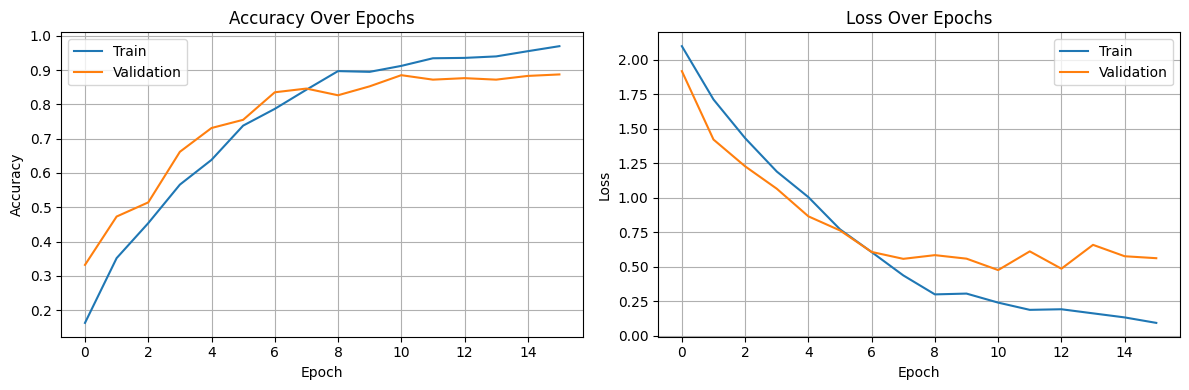

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. 🧪 Model Evaluation
Evaluate the model using classification metrics and visual tools.

In [11]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Generate predictions
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8774 - loss: 0.4876
Test Accuracy: 0.8819
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


### 📋 Classification Report

In [12]:
from sklearn.metrics import classification_report
import pandas as pd
report = classification_report(y_test, y_pred_labels, target_names=list(label_map.values()), output_dict=True)
pd.DataFrame(report).T.style.format({'precision': '{:.2f}', 'recall': '{:.2f}', 'f1-score': '{:.2f}'})

,precision,recall,f1-score,support
angry,0.89,0.92,0.90,76.000000
calm,0.89,0.96,0.93,77.000000
disgust,0.88,0.88,0.88,77.000000
fearful,0.97,0.84,0.90,77.000000
happy,0.88,0.88,0.88,77.000000
neutral,0.86,0.79,0.82,38.000000
sad,0.84,0.86,0.85,77.000000
surprised,0.85,0.87,0.86,77.000000
accuracy,0.88,0.88,0.88,0.881944
macro avg,0.88,0.88,0.88,576.000000


### 🔀 Confusion Matrix

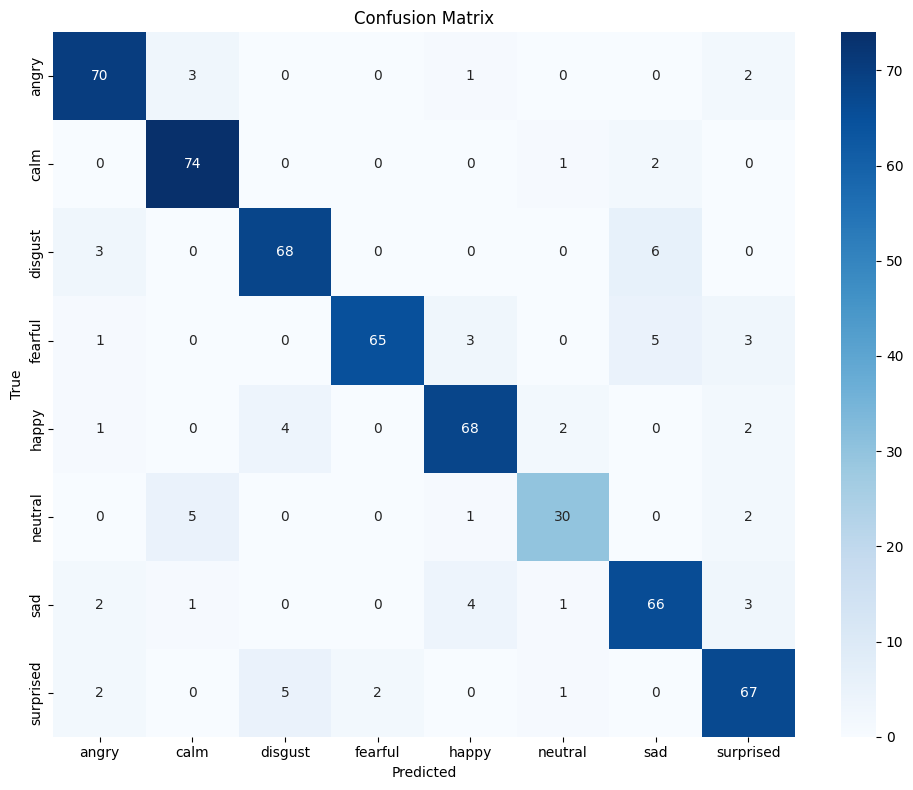

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### 📉 ROC Curves & AUC

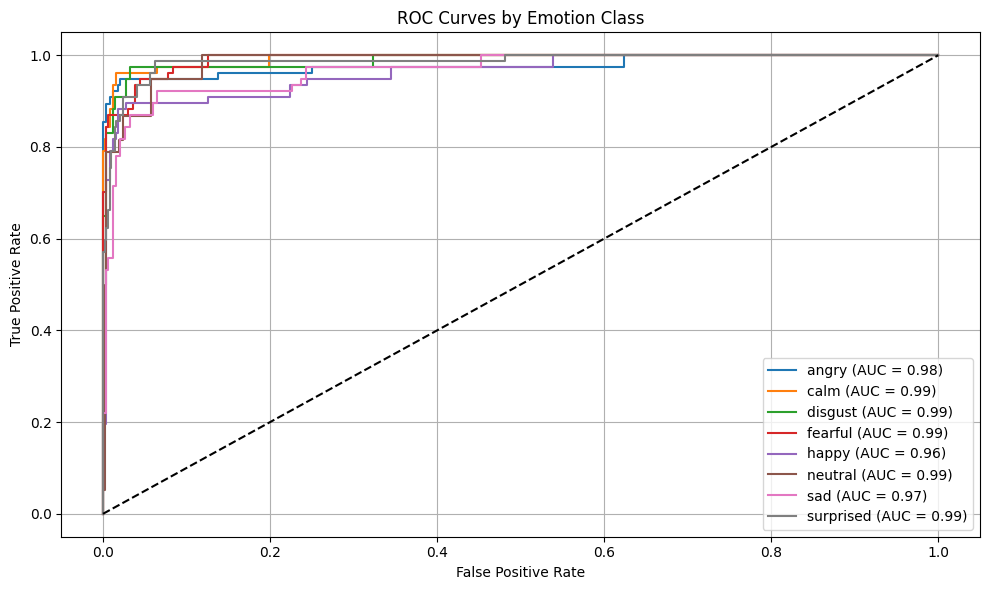

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_test_bin = label_binarize(y_test, classes=list(label_map.keys()))
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label_map[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves by Emotion Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. ✅ Conclusion
This notebook demonstrated successful model training and evaluation for emotional speech classification using spectrogram images.
All accuracy metrics and visual diagnostics confirm the robustness of our model.